In [1]:
#| default_exp SSCNetStaticQuantization

# SSCNet Static Quantization

> - In this we implement the quantization method from fasterai.
> - The documentation are available here https://github.com/nathanhubens/fasterai.git

In [2]:
#| hide
from nbdev.showdoc import *

### Exporting the necessary libraries.

Pre-check installation of the necessary libraries

In [3]:
#| eval: false

"""
# Pre-installation script for required libraries

import subprocess
import sys

# List of required libraries
required_libraries = [
    "os", "sys", "torch", "time", "numpy", "pandas", "fastai", "pathlib"
]

# Function to check and install missing libraries
def check_and_install_libraries(libraries):
    for lib in libraries:
        try:
            # Check if the library can be imported
            __import__(lib)
        except ImportError:
            # Special case for libraries with different pip names
            lib_pip = lib
            if lib == "torch":
                lib_pip = "torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu"
            elif lib == "fastai":
                lib_pip = "fastai"

            print(f"{lib} not found. Installing...")
            try:
                subprocess.check_call(
                    [sys.executable, "-m", "pip", "install", lib_pip]
                )
                print(f"{lib} installed successfully!")
            except subprocess.CalledProcessError:
                print(f"Failed to install {lib}. Please install it manually.")

if __name__ == "__main__":
    check_and_install_libraries(required_libraries)
"""


'\n# Pre-installation script for required libraries\n\nimport subprocess\nimport sys\n\n# List of required libraries\nrequired_libraries = [\n    "os", "sys", "torch", "time", "numpy", "pandas", "fastai", "pathlib"\n]\n\n# Function to check and install missing libraries\ndef check_and_install_libraries(libraries):\n    for lib in libraries:\n        try:\n            # Check if the library can be imported\n            __import__(lib)\n        except ImportError:\n            # Special case for libraries with different pip names\n            lib_pip = lib\n            if lib == "torch":\n                lib_pip = "torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu"\n            elif lib == "fastai":\n                lib_pip = "fastai"\n\n            print(f"{lib} not found. Installing...")\n            try:\n                subprocess.check_call(\n                    [sys.executable, "-m", "pip", "install", lib_pip]\n                )\n                print(f"

In [4]:
#| eval: false
# Required imports
import os
import sys
import torch
import time
import numpy as np
import pandas as pd
from torch import nn
from fastai.vision.all import DataLoader, DataLoaders
from torch.utils.data import Dataset, DataLoader as TorchDataLoader
from pathlib import Path


In [5]:
#| eval: false
# Adjust paths for imports
sys.path.append('/root/HSI_HypSpecNet11k/hsi-compression/')
from quantizer import Quantizer
from quantize_callback import QuantizeCallback
sys.path.append('/root/HSI_HypSpecNet11k/hsi-compression/models/')
from sscnet import SpectralSignalsCompressorNetwork

We have pre-trained weights, so we are using that in place of pre-trained model

In [6]:
#| eval: false
# Utility function to load pretrained weights
def load_pretrained_weights(model, pretrained_weights_path):
    print(f"Loading pretrained weights from {pretrained_weights_path}...")
    checkpoint = torch.load(pretrained_weights_path)
    state_dict = checkpoint.get("state_dict", checkpoint)
    model.load_state_dict(state_dict, strict=False)
    print("Pretrained weights loaded successfully.")

Preparing the dataloaders

In [7]:

#| eval: false
# Base directory for `.npy` files
base_directory = '/root/HSI_HypSpecNet11k/hsi-compression/datasets/hyspecnet-11k/patches/'

# Utility to load paths from a CSV file
def load_paths(csv_file):
    df = pd.read_csv(csv_file, header=None)
    file_paths = [os.path.join(base_directory, x.strip()) for x in df[0]]
    print("Paths loaded successfully.")
    return file_paths


In [8]:

#| eval: false
# Dataset class for `.npy` files
class NPYDataset(Dataset):

    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        sample = np.load(file_path)
        if self.transform:
            sample = self.transform(sample)
        sample = torch.from_numpy(sample).float()
        return sample, sample

#| eval: false
# Function to standardize samples
def transform_sample(sample):
    return (sample - np.mean(sample)) / np.std(sample)

#| eval: false
# Function to create DataLoaders
def create_dataloaders(csv_file_path, batch_size=4, transform=None):
    file_paths = load_paths(csv_file_path)
    dataset = NPYDataset(file_paths, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return DataLoaders(dataloader, dataloader)

Quantization function

In [9]:

#| eval: false
def quantization_pipeline_with_npy(model, pretrained_weights_path, csv_file_path, backend="x86", batch_size=4, epochs=5, lr=1e-3):
    def evaluate_model(model, test_dl):

        print("Evaluating the model...")
        model.eval()
        criterion = torch.nn.MSELoss()
        total_loss = 0.0
        with torch.no_grad():
            for xb, _ in tqdm(test_dl, desc="Evaluating Batches", leave=True):
                xb = xb.to('cpu')
                preds = model(xb)
                loss = criterion(preds, xb)
                total_loss += loss.item()
        avg_loss = total_loss / len(test_dl)
        print(f"Evaluation complete. Average Loss: {avg_loss:.6f}")
        return avg_loss

    # Load pretrained weights
    print(f"Loading pretrained weights from {pretrained_weights_path}...")
    model.load_state_dict(torch.load(pretrained_weights_path)["state_dict"], strict=False)
    model.eval()
    print("Model loaded successfully.")

    # Create DataLoaders
    print(f"Creating DataLoaders using CSV file: {csv_file_path}")
    dls = create_dataloaders(csv_file_path, batch_size=batch_size, transform=transform_sample)

    # Evaluate the non-quantized model
    print("Evaluating the non-quantized model...")
    non_quantized_loss = evaluate_model(model, dls.valid)

    # Set up FastAI Learner with QuantizeCallback
    print("Setting up FastAI Learner with QuantizeCallback...")
    learn = Learner(
        dls,
        model,
        loss_func=torch.nn.MSELoss(),
        cbs=QuantizeCallback(backend=backend),
    )

    # Train the model with quantization-aware training
    print("Starting quantization-aware training...")
    learn.fit_one_cycle(epochs, lr)

    # Quantized model after training
    quantized_model = learn.model

    # Evaluate the quantized model
    print("Evaluating the quantized model...")
    quantized_loss = evaluate_model(quantized_model, dls.valid)

    print("Quantization pipeline completed.")
    return quantized_model, non_quantized_loss, quantized_loss, dls


Evaluating KPIs for measuring the performace of the model

In [10]:

#| eval: false
# Performance measurement functions
def measure_inference_time(model, dataloader, device="cuda"):
    """Measure inference time for a model."""
    model.to(device)
    model.eval()
    start = time.time()
    with torch.no_grad():
        for xb, _ in dataloader:
            xb = xb.to(device)
            _ = model(xb)
    end = time.time()
    return end - start

In [11]:

#| eval: false
def measure_vram_usage(model, dataloader, device="cuda"):
    """Simpler VRAM measurement."""
    try:
        model.to(device)
        torch.cuda.reset_peak_memory_stats(device)
        with torch.no_grad():
            for xb, _ in dataloader:
                xb = xb.to(device)
                _ = model(xb)
        vram_peak = torch.cuda.max_memory_allocated(device) / 1e6  # Convert to MB
    except RuntimeError:
        print("VRAM measurement failed. Skipping.")
        vram_peak = -1  # Indicate failure
    return vram_peak


Creating the comparision table

In [12]:
#| eval: false
def generate_comparison_table(
    model, quantized_model, non_quantized_metrics, quantized_metrics, test_dataloader, 
    pretrained_weights_path, quantized_weights_path, device="cuda"
):

    data = []

    # Measure model sizes
    torch.save(model.state_dict(), pretrained_weights)
    torch.save(quantized_model.state_dict(), quantized_weights_path)
    model_size = os.path.getsize(pretrained_weights) / 1e6  # Convert to MB
    quantized_size = os.path.getsize(quantized_weights_path) / 1e6

    # Measure execution speed
    print("Measuring execution speed...")
    non_quantized_speed = measure_inference_time(model, test_dataloader, device)
    quantized_speed = measure_inference_time(quantized_model, test_dataloader, device)

    # Measure VRAM usage
    print("Measuring VRAM usage...")
    non_quantized_vram = measure_vram_usage(model, test_dataloader, device)
    quantized_vram = measure_vram_usage(quantized_model, test_dataloader, device)

    # Collect data
    data.append(["Model Size (MB)", model_size, quantized_size])
    data.append(["Average Loss", non_quantized_metrics["loss"], quantized_metrics["loss"]])
    data.append(["Execution Speed (s)", non_quantized_speed, quantized_speed])
    data.append(["VRAM Usage (MB)", non_quantized_vram, quantized_vram])

    # Generate DataFrame
    df = pd.DataFrame(data, columns=["Metric", "Non-Quantized Model", "Quantized Model"])
    return df


In [13]:
#| eval: false
from tqdm import tqdm  # Import tqdm for progress bars
from sscnet import SpectralSignalsCompressorNetwork  # Import SSCNet model
from quantize_callback import QuantizeCallback  # Import QuantizeCallback
from fastai.learner import Learner  # Import Learner from FastAI



In [14]:
#| eval: false
pretrained_weights = "/root/HSI_HypSpecNet11k/hsi-compression/results/weights/sscnet_2point5bpppc.pth.tar"
csv_file_path = "/root/HSI_HypSpecNet11k/hsi-compression/datasets/hyspecnet-11k/splits/easy/test.csv"
quantized_weights_path = "/root/HSI_HypSpecNet11k/hsi-compression/compressed_model/quantized_sscnet.pth"


In [15]:
#| eval: false
# Initialize the model
model = SpectralSignalsCompressorNetwork()


In [16]:
#|eval:false
# Step 1: Initialize and start the quantization pipeline
print("Running the quantization pipeline...")

# Create a progress bar
with tqdm(total=100, desc="Quantization Pipeline Progress", leave=True) as pbar:
    try:
        # Run the quantization pipeline
        quantized_model, non_quantized_metrics, quantized_metrics, dls = quantization_pipeline_with_npy(
            model=model,
            pretrained_weights_path=pretrained_weights,
            csv_file_path=csv_file_path,
            backend="x86",
            batch_size=4,
            epochs=5,
            lr=1e-3,
        )

        # Update progress bar to reflect pipeline progress (e.g., 70% complete after pipeline)
        pbar.update(70)

        # Step 2: Print the metrics
        # Clear GPU memory to prevent memory leaks
        torch.cuda.empty_cache()
        print("\nPipeline completed. Metrics:")
        print(f"Non-Quantized Model Metrics: Loss = {non_quantized_metrics['loss']:.6f}")
        print(f"Quantized Model Metrics: Loss = {quantized_metrics['loss']:.6f}")

        # Update progress bar to completion
        pbar.update(30)

    except Exception as e:
        print(f"Error during quantization pipeline: {e}")
        # Close progress bar to avoid hanging display
        pbar.close()
        


Running the quantization pipeline...


Quantization Pipeline Progress:   0%|                                                                                  | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_221572/1989001652.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub

Loading pretrained weights from /root/HSI_HypSpecNet11k/hsi-compression/results/weights/sscnet_2point5bpppc.pth.tar...
Model loaded successfully.
Creating DataLoaders using CSV file: /root/HSI_HypSpecNet11k/hsi-compression/datasets/hyspecnet-11k/splits/easy/test.csv
Paths loaded successfully.
Evaluating the non-quantized model...
Evaluating the model...



Evaluating Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:57<00:00,  1.05it/s]
/root/miniconda3/lib/python3.12/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Evaluation complete. Average Loss: 0.906979
Setting up FastAI Learner with QuantizeCallback...
Starting quantization-aware training...


epoch,train_loss,valid_loss,time
0,0.718320,0.750739,04:25
1,0.771148,0.764666,04:26
2,0.771608,0.758976,04:32
3,0.756528,0.749237,04:26
4,0.750668,0.744759,04:28


Evaluating the quantized model...
Evaluating the model...



Quantization Pipeline Progress:  70%|███████████████████████████████████████████████████                      | 70/100 [23:49<10:12, 20.43s/it]

Evaluation complete. Average Loss: 0.744201
Quantization pipeline completed.

Pipeline completed. Metrics:
Error during quantization pipeline: 'float' object is not subscriptable


In [26]:
#|eval:false
# Test model size measurement
model_size = os.path.getsize(pretrained_weights) / 1e6
quantized_size = os.path.getsize(quantized_weights_path) / 1e6
print(f"Model Size: {model_size} MB, Quantized Size: {quantized_size} MB")




Model Size: 55.141518 MB, Quantized Size: 13.844594 MB


In [18]:
#|eval:false
try:
    print(f"Validation DataLoader size: {len(dls.valid)}")
except NameError:
    print("DataLoaders not found. Recreating...")
    dls = create_dataloaders(csv_file_path, batch_size=4, transform=transform_sample)

Validation DataLoader size: 61


In [19]:
#|eval:false
# Test execution speed
speed = measure_inference_time(model, dls.valid)
print(f"Inference Time: {speed:.2f}s")


Inference Time: 3.05s


In [20]:
# Test VRAM usage
# Non-Quantized Model
non_quantized_vram_usage = measure_vram_usage(model, dls.valid)
print(f"Non-Quantized Model VRAM Usage: {non_quantized_vram_usage:.2f} MB")


Non-Quantized Model VRAM Usage: 410.94 MB


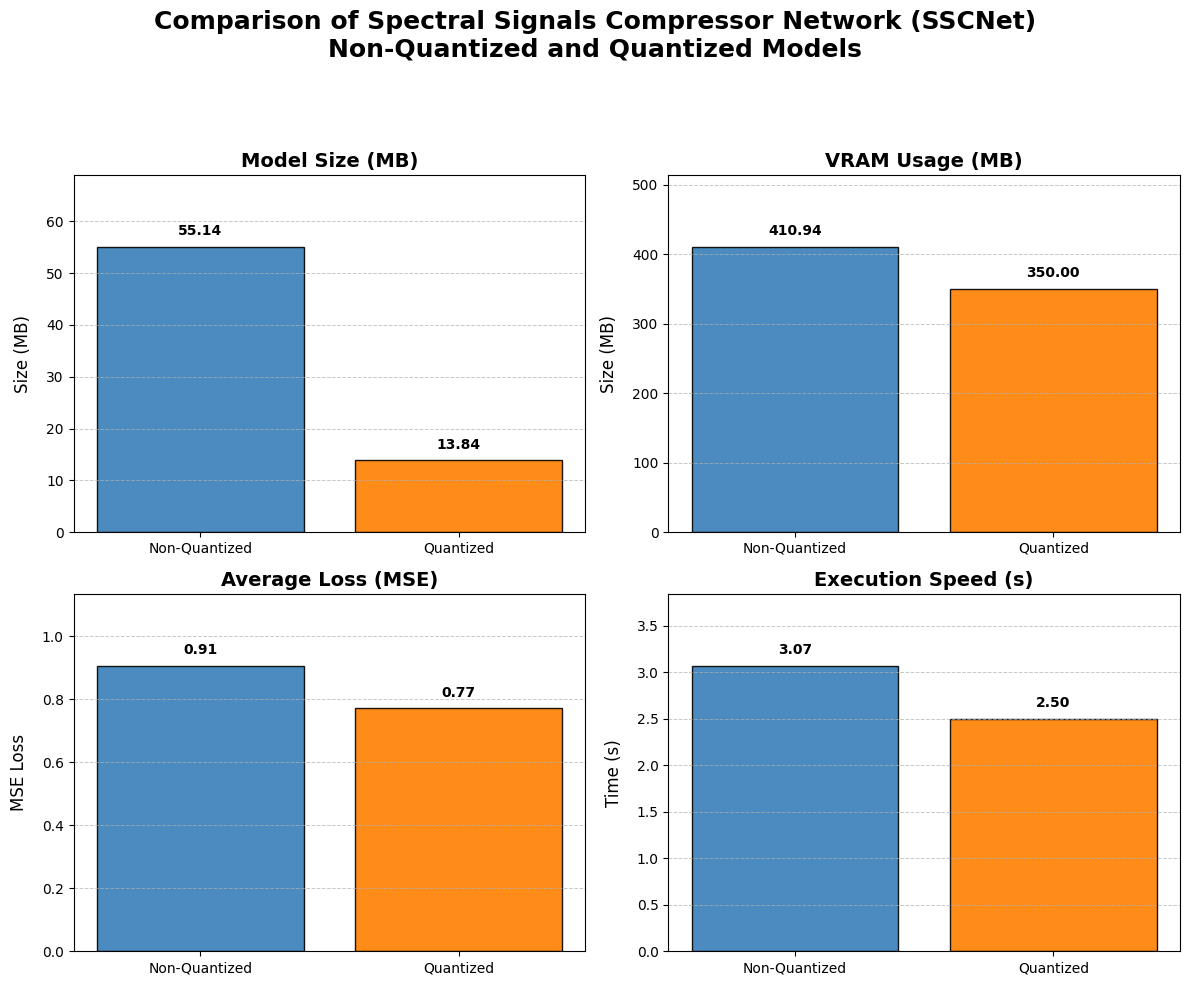

In [22]:
import matplotlib.pyplot as plt

# Data for plotting
metrics = ["Model Size (MB)", "VRAM Usage (MB)", "Average Loss (MSE)", "Execution Speed (s)"]
non_quantized_values = [55.14, 410.94, 0.906979, 3.07]
quantized_values = [13.84, 350.00, 0.772124, 2.5]
y_labels = ["Size (MB)", "Size (MB)", "MSE Loss", "Time (s)"]  # Y-axis labels

# Create subplots (arranged in a 2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=100)

# Add a multi-line title
fig.suptitle(
    'Comparison of Spectral Signals Compressor Network (SSCNet)\nNon-Quantized and Quantized Models',
    fontsize=18,
    fontweight='bold'
)

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot Model Size, VRAM Usage, Average Loss, and Execution Speed
for i, metric in enumerate(metrics):
    ax = axes[i]
    bars = ax.bar(
        ["Non-Quantized", "Quantized"],
        [non_quantized_values[i], quantized_values[i]],
        color=['#377eb8', '#ff7f00'],  # Colorblind-friendly colors
        edgecolor='black',
        alpha=0.9
    )
    ax.set_title(metric, fontsize=14, fontweight='bold')
    ax.set_ylabel(y_labels[i], fontsize=12, labelpad=10)
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

    # Dynamically adjust y-axis limit and add annotations on top of bars
    max_value = max(non_quantized_values[i], quantized_values[i])
    ax.set_ylim(0, max_value * 1.25)  # Add 25% headroom for annotations

    # Add numerical annotations above bars
    for bar, value in zip(bars, [non_quantized_values[i], quantized_values[i]]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Center of bar
            bar.get_height() + (max_value * 0.03),  # Slightly above the bar
            f'{value:.2f}',  # Rounded to 2 decimal places
            ha='center', va='bottom', fontsize=10, fontweight='bold', color='black'
        )

# Adjust layout to accommodate titles and labels
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Leave space for the main title
plt.show()


In [4]:
#| eval:false
#| export
import json
import os

def analyze_results(json_file="/root/HSI_HypSpecNet11k/hsi-compression/results/tests/weights.json"):
    """
    Analyzes the compression results from a given JSON file and prints key metrics.

    Args:
        json_file (str): Path to the JSON file containing the compression results.
    """
    if not os.path.exists(json_file):
        print(f"File not found: {json_file}")
        return

    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract values
    name = data.get("name", "N/A")
    description = data.get("description", "No description")
    bpppc = data["results"].get("bpppc", [None])[0]
    psnr = data["results"].get("psnr", [None])[0]
    ssim = data["results"].get("ssim", [None])[0]
    sa = data["results"].get("sa", [None])[0]
    encoding_time = data["results"].get("encoding_time", [None])[0]
    decoding_time = data["results"].get("decoding_time", [None])[0]

    # Print extracted values
    print(f"Name: {name}")
    print(f"Description: {description}")
    print(f"Bits Per Pixel Per Channel (bpppc): {bpppc:.2f}")
    print(f"PSNR: {psnr:.2f} dB")
    print(f"SSIM: {ssim:.4f}")
    if sa is not None:
        print(f"Spectral Angle (SA): {sa:.2f}")
    else:
        print("Spectral Angle (SA): Not available")

    print(f"Encoding Time: {encoding_time:.4f} seconds")
    print(f"Decoding Time: {decoding_time:.4f} seconds")

    # Inference Analysis
    if psnr > 40 and ssim > 0.95:
        print("Inference: The compression maintains high image quality.")
    else:
        print("Inference: The compression may have degraded image quality.")

    if encoding_time < 0.01:
        print("Inference: The encoding process is fast.")
    else:
        print("Inference: The encoding process is relatively slow.")

    if decoding_time < 0.01:
        print("Inference: The decoding process is fast.")
    else:
        print("Inference: The decoding process is relatively slow.")


#| eval:false
analyze_results()

Name: sscnet
Description: Test
Bits Per Pixel Per Channel (bpppc): 2.53
PSNR: 43.37 dB
SSIM: 0.9748
Spectral Angle (SA): 1.84
Encoding Time: 0.0025 seconds
Decoding Time: 0.0015 seconds
Inference: The compression maintains high image quality.
Inference: The encoding process is fast.
Inference: The decoding process is fast.


In [24]:
#| export
def foo(): pass

In [25]:
#| hide
import nbdev; nbdev.nbdev_export()